In [1]:
import pandas as pd
from tvtk.api import tvtk
from tvtk.common import configure_input, configure_source_data
from tvtk.common import configure_connection, configure_input, configure_input_data, configure_outputs
import gridded 
import xarray as xr
import scipy.interpolate
import numpy as np
import netCDF4
import matplotlib.pyplot as plt


In [2]:
def grid2poly(grid):
    faces = grid.faces
    points = grid.nodes

    points[:, 0] = np.mod(points[:, 0], 360)
    n_cells = faces.shape[0]

    cell_array = tvtk.CellArray()

    counts = (~faces.mask).sum(axis=1)
    assert faces.min() >= 0, 'expected 0 based faces'
    cell_idx = np.c_[counts, faces.filled(-999)].ravel()
    cell_idx = cell_idx[cell_idx != -999]
    cell_array.set_cells(n_cells, cell_idx)

    # fill in the properties
    polydata = tvtk.PolyData()
    # fill in z dimension
    polydata.points = np.c_[points, np.zeros_like(points[:, 0])]
    polydata.polys = cell_array
    return polydata

def update_data(ds, polydata, t=0):
    for key in ['water_level', 'water_level_surge']:
        arr = ds.variables[key][t, ...]
        array = tvtk.FloatArray()
        array.from_array(arr)
        array.name = key
        polydata.cell_data.add_array(array)
    polydata.modified()

In [3]:
def setup_pipeline(polydata, width=1000, height=1000):
    # resample = tvtk.PResampleFilter()
    resample = tvtk.ResampleToImage()
    cell2point = tvtk.CellDataToPointData()
    # setup the pipeline
    configure_input(cell2point, polydata)

    configure_input(resample, cell2point)

    resample.sampling_dimensions = np.array([width, height, 1])

    # TODO: check if this can be left out
    resample.modified()
    resample.update()
    polydata.modified()
    return resample


In [18]:
img_size = (1000, 1000)


ds = netCDF4.Dataset('/Users/baart_f/data/gtsm/glossis/2021041906_DflowFM_gtsm_waterlevel_00_fc.nc')
grid = gridded.pyugrid.ugrid.UGrid.from_nc_dataset(ds)
polydata =  grid2poly(grid)
resample = setup_pipeline(polydata)



154 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
update_data(ds, polydata, t=0)
resample.update()
mask = np.array(resample.get_output().point_data.get_array(2))
mask = np.logical_not(mask.reshape(img_size))
surge = np.array(resample.get_output().point_data.get_array(1))
surge = surge.reshape(img_size)
surge = np.ma.masked_array(surge, mask=mask)




1.62 s ± 99.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
1.62 * 6 * 16 

155.52

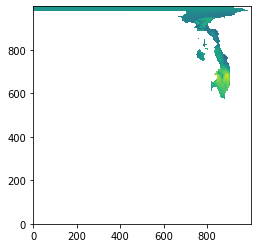

In [12]:
img = resample.get_output()
plt.imshow(surge, origin='bottom')

In [ ]:
writer = tvtk.XMLDataSetWriter()
writer.file_name = '/Users/baart_f/data/gtsm/test.vtp'
configure_input(writer, polydata)
writer.write()

In [ ]:
writer = tvtk.XMLImageDataWriter()
writer.file_name = '/Users/baart_f/data/gtsm/test.vti'

configure_input(writer, resample)
writer.print_traits()
writer.write()